In [66]:
print(fo.__file__)

/home/naveen/workspace/voxel/venv/lib/python3.8/site-packages/fiftyone/__init__.py


In [1]:
import fiftyone as fo

dataset = fo.load_dataset("copy_pipeline_data")


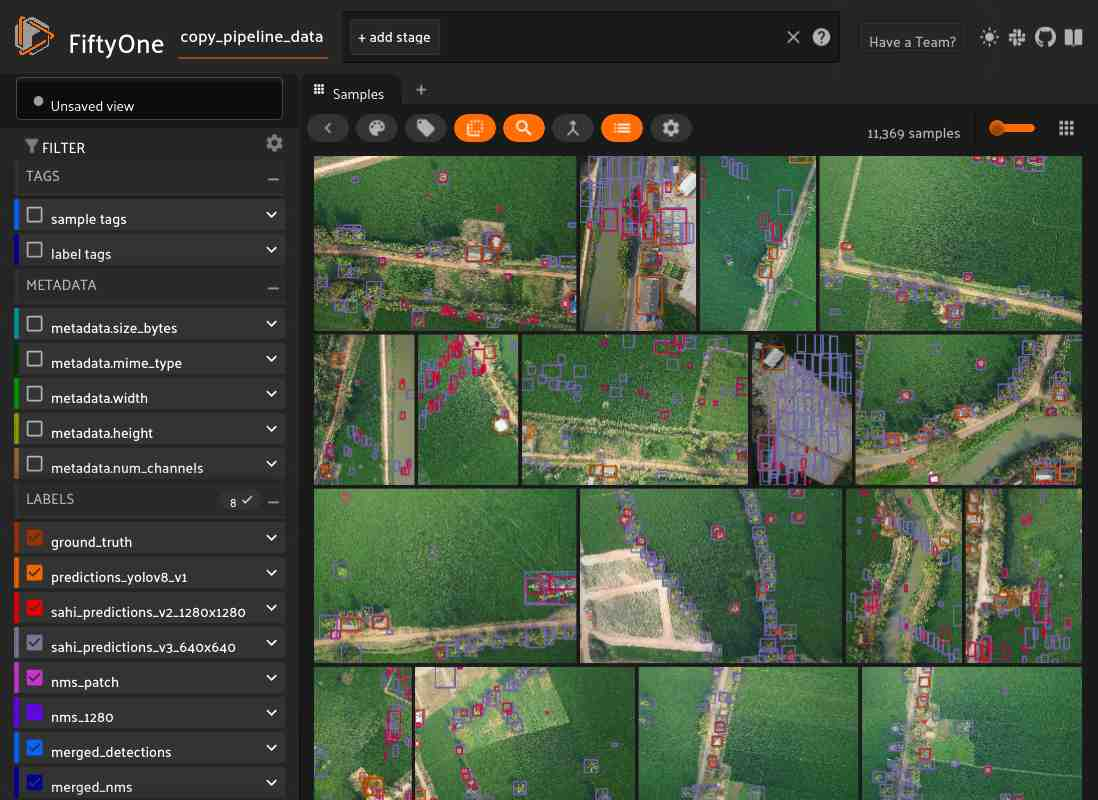

In [2]:
session = fo.launch_app(dataset)

In [ ]:
# copy = dataset.clone()
# samples = copy.take(50)
import fiftyone.utils.labels as fol


fol.perform_nms(sample_collection=dataset, in_field="sahi_predictions_v3_640x640", out_field="patch_nms", confidence_thresh=0.15, iou_thresh=0.10,classwise=True, progress=True)

ERROR! Session/line number was not unique in database. History logging moved to new session 151
   0% ||------------|     8/11369 [16.0s elapsed, 6.3h remaining, 0.5 samples/s] 

In [22]:
import fiftyone as fo
dataset = fo.load_dataset("copy_pipeline_data")

filtered_samples = [sample for sample in dataset if len(sample["sahi_predictions_v3_640x640.detections"]) > 40]

filtered_dataset = fo.Dataset(name= "filtered_patch")

filtered_dataset.add_samples(filtered_samples)

filtered_dataset.save()

 100% |█████████████████| 520/520 [59.1s elapsed, 0s remaining, 4.4 samples/s]       


In [23]:
import fiftyone as fo
dataset = fo.load_dataset("copy_pipeline_data")

filtered_samples = [sample for sample in dataset if len(sample["sahi_predictions_v2_1280x1280.detections"]) > 40]

filtered_dataset = fo.Dataset(name= "filtered_1280")

filtered_dataset.add_samples(filtered_samples)

filtered_dataset.save()

 100% |█████████████████| 753/753 [1.6m elapsed, 0s remaining, 5.1 samples/s]      


In [8]:

dataset.delete_sample_field("sahi_predictions_v3_640x640_05")
dataset.save()


In [2]:
import os

from bson import ObjectId

from fiftyone.core.document import Document, DocumentView
import fiftyone.core.frame as fofr
import fiftyone.core.frame_utils as fofu
import fiftyone.core.labels as fol
import fiftyone.core.metadata as fom
import fiftyone.core.media as fomm
import fiftyone.core.odm as foo
import fiftyone.core.utils as fou
from fiftyone.core.singletons import SampleSingleton


def merge(
        self,
        sample,
        fields=None,
        omit_fields=None,
        merge_lists=True,
        overwrite=True,
        expand_schema=True,
        validate=True,
        dynamic=False,
    ):
        """Merges the fields of the given sample into this sample.

        The behavior of this method is highly customizable. By default, all
        top-level fields from the provided sample are merged in, overwriting
        any existing values for those fields, with the exception of list fields
        (e.g., ``tags``) and label list fields (e.g.,
        :class:`fiftyone.core.labels.Detections` fields), in which case the
        elements of the lists themselves are merged. In the case of label list
        fields, labels with the same ``id`` in both samples are updated rather
        than duplicated.

        To avoid confusion between missing fields and fields whose value is
        ``None``, ``None``-valued fields are always treated as missing while
        merging.

        This method can be configured in numerous ways, including:

        -   Whether new fields can be added to the dataset schema
        -   Whether list fields should be treated as ordinary fields and merged
            as a whole rather than merging their elements
        -   Whether to merge only specific fields, or all but certain fields
        -   Mapping input sample fields to different field names of this sample

        Args:
            sample: a :class:`fiftyone.core.sample.Sample`
            fields (None): an optional field or iterable of fields to which to
                restrict the merge. May contain frame fields for video samples.
                This can also be a dict mapping field names of the input sample
                to field names of this sample
            omit_fields (None): an optional field or iterable of fields to
                exclude from the merge. May contain frame fields for video
                samples
            merge_lists (True): whether to merge the elements of list fields
                (e.g., ``tags``) and label list fields (e.g.,
                :class:`fiftyone.core.labels.Detections` fields) rather than
                merging the entire top-level field like other field types.
                For label lists fields, existing
                :class:`fiftyone.core.label.Label` elements are either replaced
                (when ``overwrite`` is True) or kept (when ``overwrite`` is
                False) when their ``id`` matches a label from the provided
                sample
            overwrite (True): whether to overwrite (True) or skip (False)
                existing fields and label elements
            expand_schema (True): whether to dynamically add new fields
                encountered to the dataset schema. If False, an error is raised
                if any fields are not in the dataset schema
            validate (True): whether to validate values for existing fields
            dynamic (False): whether to declare dynamic embedded document
                fields
        """
        if sample.media_type != self.media_type:
            raise ValueError(
                "Cannot merge sample with media type '%s' into sample with "
                "media type '%s'" % (sample.media_type, self.media_type)
            )

        if self.media_type == fomm.VIDEO:
            (
                fields,
                frame_fields,
                omit_fields,
                omit_frame_fields,
            ) = self._parse_fields_video(
                fields=fields, omit_fields=omit_fields
            )

        super().merge(
            sample,
            fields=fields,
            omit_fields=omit_fields,
            merge_lists=merge_lists,
            overwrite=overwrite,
            expand_schema=expand_schema,
            validate=validate,
            dynamic=dynamic,
        )

        if self.media_type == fomm.VIDEO:
            self.frames.merge(
                sample.frames,
                fields=frame_fields,
                omit_fields=omit_frame_fields,
                merge_lists=merge_lists,
                overwrite=overwrite,
                expand_schema=expand_schema,
                validate=validate,
                dynamic=dynamic,
            )

In [85]:
for sample in dataset:
    sample["merged_detections"] = sample.sahi_predictions_v2_1280x1280.copy()
    sample.merged_detections.merge(
        sample.sahi_predictions_v3_640x640,
        merge_lists=True, 
        overwrite=True,    
    )

    sample.save()

In [103]:
session = fo.launch_app(dataset)

In [89]:
import fiftyone.utils.labels as fol


fol.perform_nms(sample_collection=dataset, in_field="merged_detections", out_field="merged_nms", confidence_thresh=0.15, iou_thresh=0.10,classwise=True, progress=True)

 100% |█████████████| 11369/11369 [2.2m elapsed, 0s remaining, 83.5 samples/s]       


In [95]:
copy = dataset.clone()

In [100]:
iou = dataset.evaluate_detections(
    "ground_truth",
    gt_field="merged_nms",
    eval_key="nms",
    compute_mAP=True,
    classwise=False
)

Evaluating detections...
 100% |█████████████| 11369/11369 [6.8m elapsed, 0s remaining, 34.0 samples/s]       
Performing IoU sweep...
 100% |█████████████| 11369/11369 [3.9m elapsed, 0s remaining, 40.2 samples/s]      


In [102]:
for sample in dataset:
    # print(sample)
    for i in range(0,len(sample.merged_nms.detections)):
        
        if 'nms_iou' not in sample.merged_nms.detections[i]:
            
            # print("yes")
            sample.merged_nms.detections[i].tags.append('gt_not_matching_merged')
            sample.save()
print("done")


done



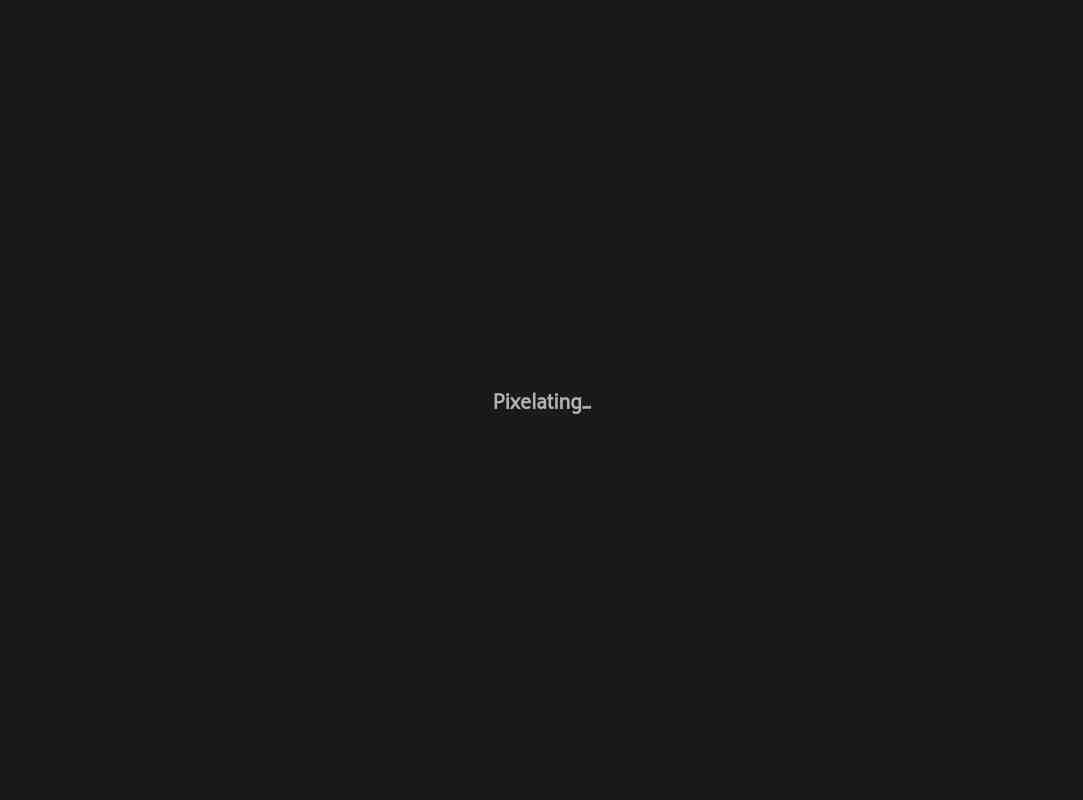

In [4]:
session = fo.launch_app(dataset)


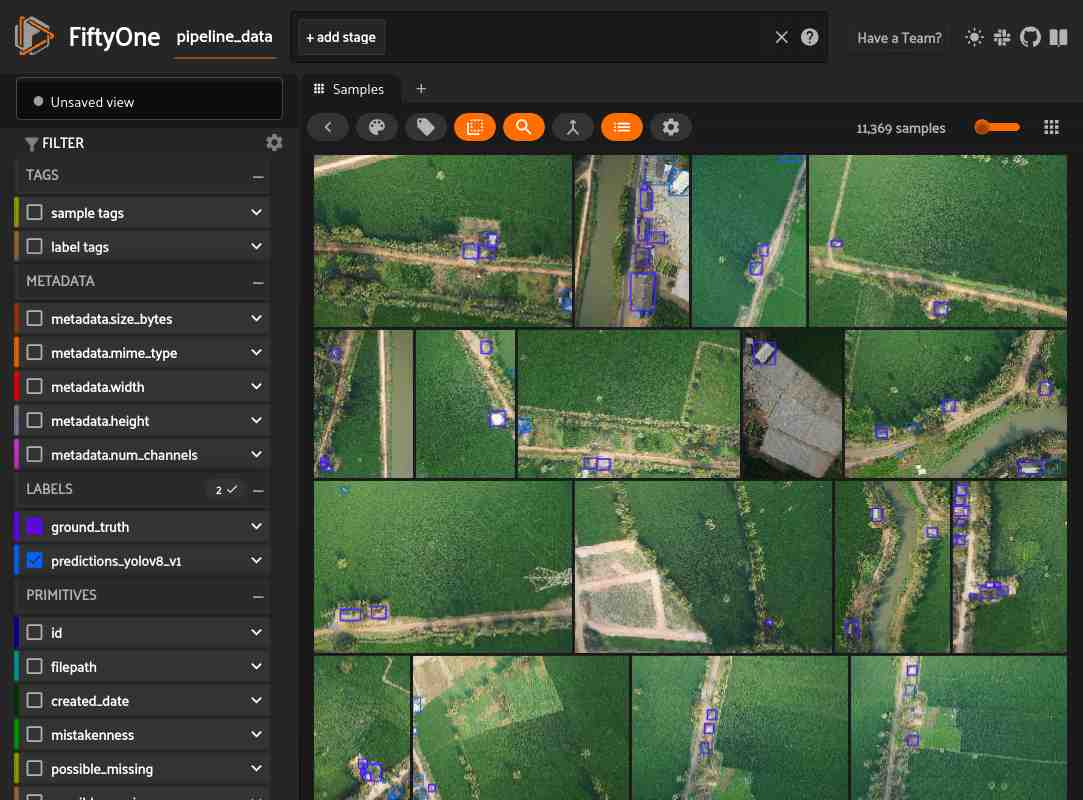

In [6]:
from fiftyone import ViewField as F
from datetime import datetime

query_date = datetime(2023, 9, 19, 0, 0, 0)
view = dataset.match(F("created_date") < query_date)
session.view = view